In [1]:
import pandas as pd
import numpy as np

#import acquire
#import prepare

import seaborn as sns
import matplotlib.pyplot as plt 


import wrangle as w

from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 

import warnings
warnings.filterwarnings("ignore")

## Initial Questions

1. Will more bedrooms and bathrooms drive house value up?


2. Does lot size sqft increase home value?


3. Does the month of the transaction of the home affect the price of the home?


4. Are Orange County home values higher vs. Los Angeles and Ventura home values?



In [2]:
df = w.get_zillow_data()
df.head()

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value
0,1940.0,6750.0,0.279112,-118388723.0,34182197.0,1,1.0,3.0,6037.0,1114.0,330387.0
1,1936.0,8098.0,0.158130,-118398122.0,34180389.0,1,3.0,3.0,6037.0,2479.0,174155.0
2,1956.0,6049.0,-0.019678,-118402898.0,34181471.0,1,2.0,3.0,6037.0,1566.0,534455.0
3,1949.0,9411.0,0.005471,-118410984.0,34182042.0,1,1.0,2.0,6037.0,1287.0,330938.0
4,1948.0,7181.0,0.089711,-118407191.0,34181941.0,1,1.0,3.0,6037.0,1706.0,440099.0


In [3]:
df.shape

(51612, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51612 entries, 0 to 51611
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year_built         51612 non-null  float64
 1   lot_sqft           51612 non-null  float64
 2   logerror           51612 non-null  float64
 3   long               51612 non-null  float64
 4   lat                51612 non-null  float64
 5   transaction_month  51612 non-null  int64  
 6   bathrooms          51612 non-null  float64
 7   bedrooms           51612 non-null  float64
 8   fips               51612 non-null  float64
 9   sqft               51612 non-null  float64
 10  home_value         51612 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 4.3 MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year_built,51612.0,1.960287e+03,21.481517,1.862000e+03,1.949000e+03,1.958000e+03,1.973000e+03,2.016000e+03
lot_sqft,51612.0,7.229715e+03,2908.099896,5.000000e+02,5.594000e+03,6.656000e+03,8.060000e+03,1.999900e+04
logerror,51612.0,1.687623e-02,0.173454,-4.655420e+00,-2.445563e-02,6.788081e-03,3.943327e-02,5.262999e+00
long,51612.0,-1.182002e+08,348104.514160,-1.194484e+08,-1.183924e+08,-1.181525e+08,-1.179511e+08,-1.175559e+08
lat,51612.0,3.400763e+07,243978.009776,3.334071e+07,3.383288e+07,3.400462e+07,3.417632e+07,3.471836e+07
transaction_month,51612.0,5.039894e+00,2.344391,1.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00,9.000000e+00
bathrooms,51612.0,2.157802e+00,0.841766,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
bedrooms,51612.0,3.264590e+00,0.868132,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
fips,51612.0,6.048721e+03,20.900511,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
sqft,51612.0,1.756618e+03,723.143793,3.200000e+02,1.245000e+03,1.589000e+03,2.109000e+03,8.243000e+03


## Prepare

In [6]:
df = df.rename(columns={'bedroomcnt':'bedrooms', 
                   'bathroomcnt':'bathrooms',
                   'calculatedfinishedsquarefeet':'sqft',
                   'yearbuilt':'year_built',
                   'longitude':'long',
                   'latitude': 'lat',
                   'transactiondate': 'transaction_month',
                   'lotsizesquarefeet': 'lot_sqft',
                   'taxvaluedollarcnt':'home_value'})

In [7]:
df

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value
0,1940.0,6750.0,0.279112,-118388723.0,34182197.0,1,1.0,3.0,6037.0,1114.0,330387.0
1,1936.0,8098.0,0.158130,-118398122.0,34180389.0,1,3.0,3.0,6037.0,2479.0,174155.0
2,1956.0,6049.0,-0.019678,-118402898.0,34181471.0,1,2.0,3.0,6037.0,1566.0,534455.0
3,1949.0,9411.0,0.005471,-118410984.0,34182042.0,1,1.0,2.0,6037.0,1287.0,330938.0
4,1948.0,7181.0,0.089711,-118407191.0,34181941.0,1,1.0,3.0,6037.0,1706.0,440099.0
...,...,...,...,...,...,...,...,...,...,...,...
51607,1954.0,7505.0,0.003785,-118399073.0,34233216.0,9,1.0,3.0,6037.0,999.0,222136.0
51608,1958.0,8339.0,0.062060,-118400541.0,34234902.0,9,2.0,3.0,6037.0,1366.0,211616.0
51609,1973.0,7499.0,0.029647,-118421360.0,34227043.0,9,3.0,4.0,6037.0,2180.0,538107.0
51610,1954.0,6068.0,0.040940,-118419411.0,34229157.0,9,2.0,3.0,6037.0,1570.0,368839.0


In [ ]:
df['transaction_month'] = df['transaction_month'].str.replace("-", "").astype(float)

In [ ]:
df['transaction_month']= df['transaction_month'].astype(str).str[4:6].astype(int)

In [ ]:
df.info()

In [ ]:
df['transaction_month']

In [ ]:
df.transaction_month.value_counts()

In [ ]:
df['fips'].value_counts()

In [ ]:
df.isna().sum()

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

In [ ]:
df.bedrooms.value_counts()

In [ ]:
df.bathrooms.value_counts()

In [ ]:
len(df[df.sqft > 10_000])

In [8]:
df = w.clean_zillow_data(df)

In [9]:
df.bedrooms.value_counts()

3.0    23829
4.0    15200
2.0     8384
5.0     3277
1.0      496
6.0      426
Name: bedrooms, dtype: int64

In [10]:
# create a dictionary to map fips codes to county names
county_map = {6037: 'los angeles', 6111: 'ventura', 6059: 'orange'}

# use replace function to create the 'county' column
df['county'] = df['fips'].replace(county_map)

df.head()

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
0,1940.0,6750.0,0.279112,-118388723.0,34182197.0,1,1.0,3.0,6037.0,1114.0,330387.0,los angeles
1,1936.0,8098.0,0.158130,-118398122.0,34180389.0,1,3.0,3.0,6037.0,2479.0,174155.0,los angeles
2,1956.0,6049.0,-0.019678,-118402898.0,34181471.0,1,2.0,3.0,6037.0,1566.0,534455.0,los angeles
3,1949.0,9411.0,0.005471,-118410984.0,34182042.0,1,1.0,2.0,6037.0,1287.0,330938.0,los angeles
4,1948.0,7181.0,0.089711,-118407191.0,34181941.0,1,1.0,3.0,6037.0,1706.0,440099.0,los angeles


### Split data

In [11]:
train, validate, test = w.train_val_test(df)

train.shape, validate.shape, test.shape

((36128, 12), (18064, 12), (18064, 12))

## Data Exploration


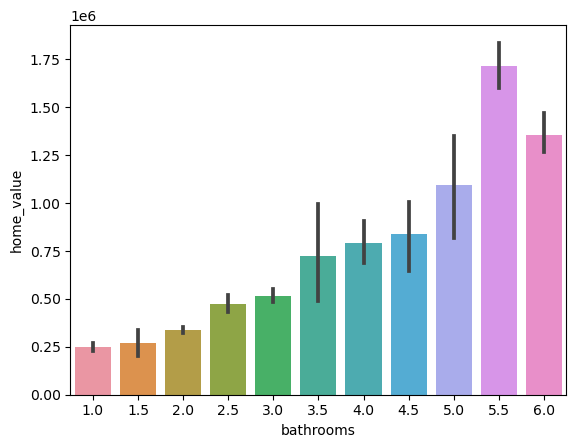

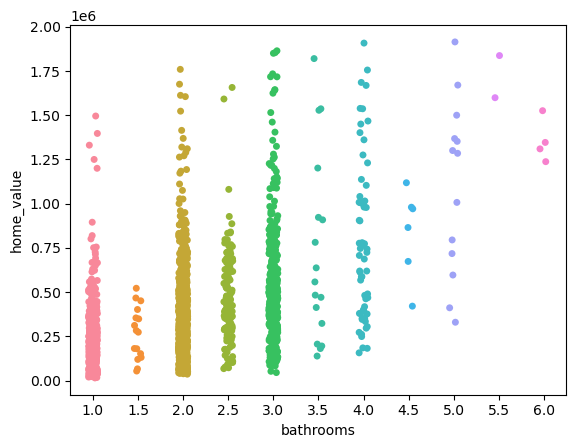

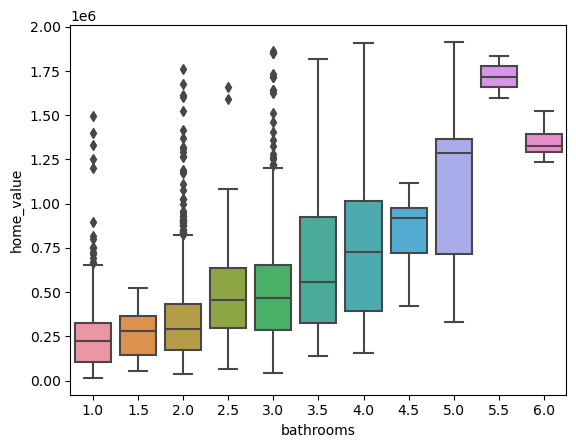

<Figure size 640x480 with 0 Axes>

In [12]:
w.plot_categorical_and_continuous_vars(train, 'bathrooms', 'home_value')

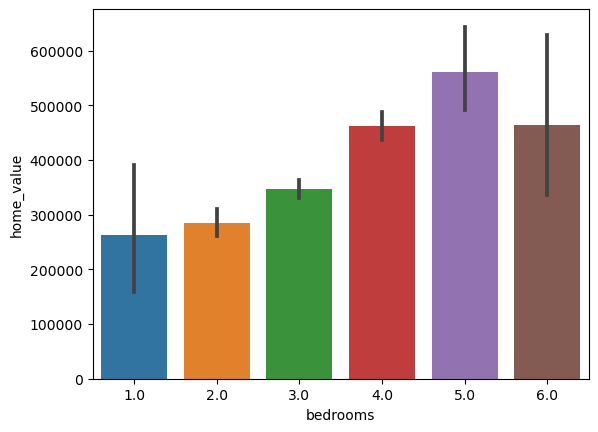

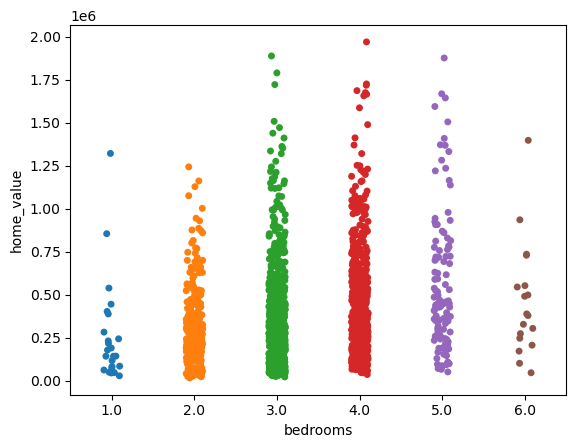

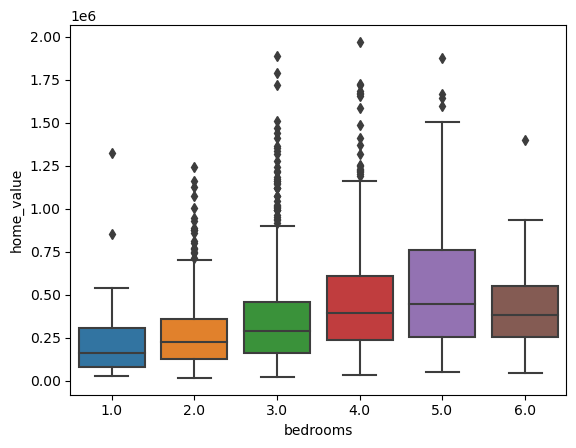

<Figure size 640x480 with 0 Axes>

In [13]:
w.plot_categorical_and_continuous_vars(train, 'bedrooms', 'home_value')

In [14]:
train

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
6939,1977.0,6000.0,-0.022559,-118030874.0,33775466.0,2,3.0,4.0,6059.0,2334.0,687000.0,orange
6471,1952.0,7220.0,-0.023329,-118125470.0,33964006.0,2,2.0,3.0,6037.0,1330.0,74121.0,los angeles
44553,1954.0,6951.0,-0.127179,-118385820.0,33807786.0,8,2.0,3.0,6037.0,2571.0,143122.0,los angeles
31088,1996.0,5735.0,0.006475,-118833422.0,34221985.0,6,2.5,4.0,6111.0,2394.0,470066.0,ventura
4038,1904.0,6793.0,-0.006862,-118281348.0,34097180.0,1,2.0,4.0,6037.0,2051.0,107819.0,los angeles
...,...,...,...,...,...,...,...,...,...,...,...,...
23030,1925.0,8375.0,0.009571,-118151500.0,34194602.0,5,2.0,4.0,6037.0,2190.0,463419.0,los angeles
24932,1956.0,6427.0,-0.066290,-117996013.0,33928503.0,5,2.0,3.0,6037.0,1314.0,178423.0,los angeles
31680,1987.0,6055.0,0.016211,-118075443.0,34065150.0,6,3.0,5.0,6037.0,1884.0,303959.0,los angeles
29484,1997.0,6143.0,-0.020053,-117790568.0,33801461.0,5,3.0,5.0,6059.0,3259.0,488280.0,orange


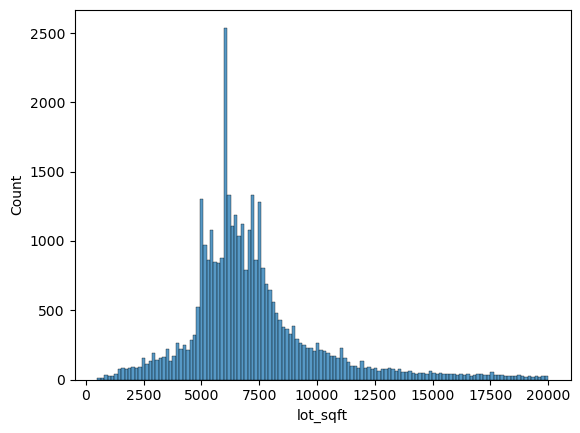

In [15]:
sns.histplot(train['lot_sqft'])
plt.show()

In [16]:
train['lot_sqft'].value_counts().sort_index()

500.0      1
540.0      3
584.0      1
594.0      1
640.0      1
          ..
19963.0    1
19979.0    1
19986.0    1
19987.0    1
19999.0    1
Name: lot_sqft, Length: 9827, dtype: int64

In [17]:
len(train[train['lot_sqft']> 30000])

0

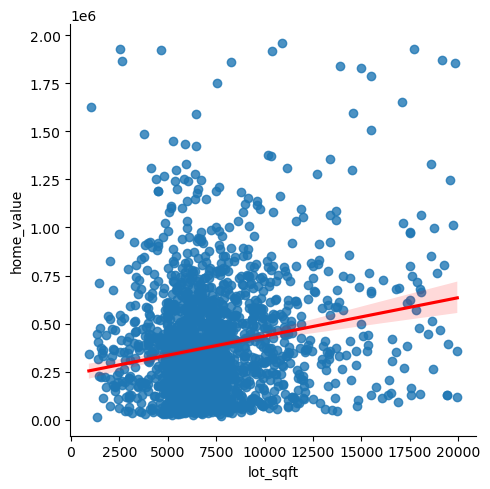

In [19]:
sns.lmplot(x = 'lot_sqft' , y = 'home_value', data = train.sample(2000), line_kws={'color': 'red'})
plt.show()

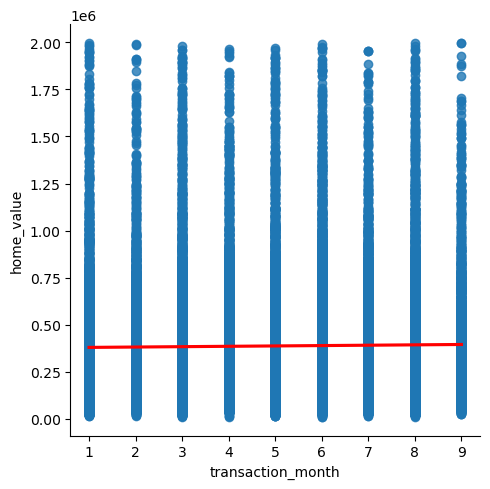

In [20]:
sns.lmplot(x = 'transaction_month' , y = 'home_value', data = train, line_kws={'color': 'red'})
plt.show()

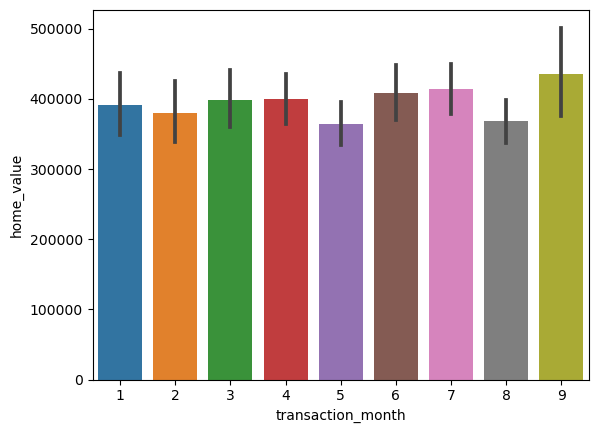

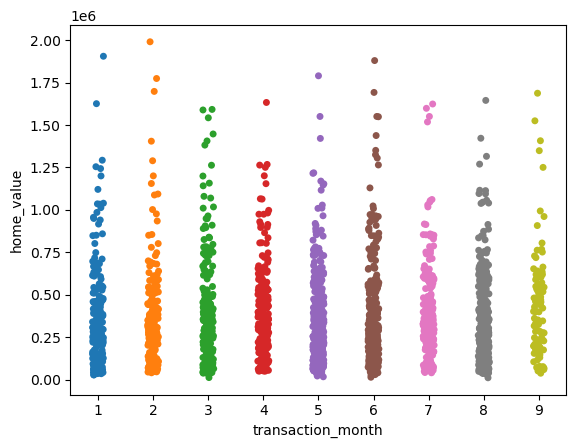

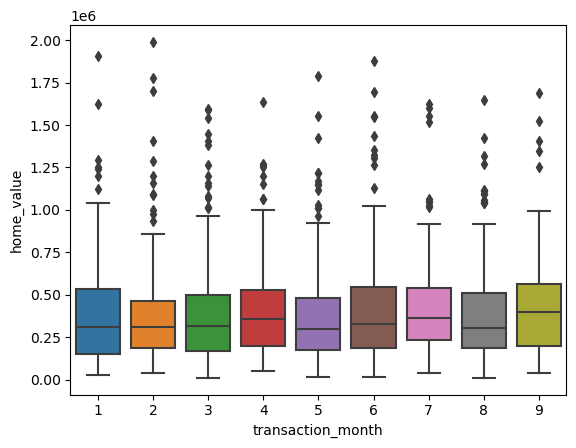

<Figure size 640x480 with 0 Axes>

In [21]:
w.plot_categorical_and_continuous_vars(train, 'transaction_month', 'home_value')

In [22]:
la_county = df['fips'] == 6037
ventura_county = df['fips'] == 6111
orange_county = df['fips'] == 6059

In [26]:
train['lot_sqft'][la_county].mean()

7375.815226976862

In [27]:
df[la_county]['home_value'].mean()

359342.935918463

In [28]:
df[ventura_county]['home_value'].mean()

383549.70469007775

In [29]:
df[orange_county]['home_value'].mean()

459852.27243856335

In [30]:
la_county

0        True
1        True
2        True
3        True
4        True
         ... 
51607    True
51608    True
51609    True
51610    True
51611    True
Name: fips, Length: 51612, dtype: bool

In [31]:
def county():
    fig, ax = plt.subplots(figsize = (7,5))
    sns.scatterplot(data = df,x = df['long'], y = df['lat'], zorder = 1,hue = 'county')
    plt.show()

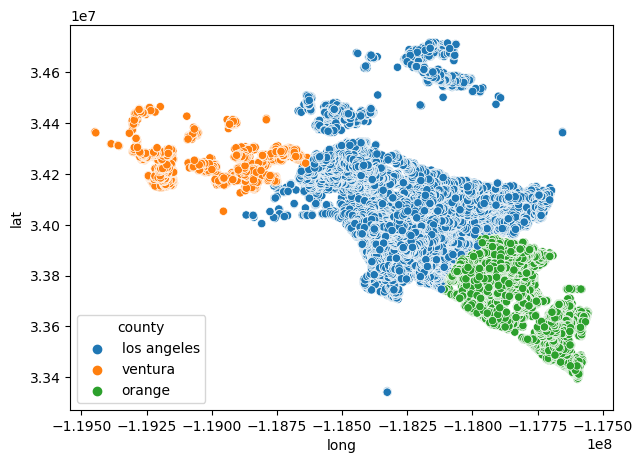

In [32]:
county()

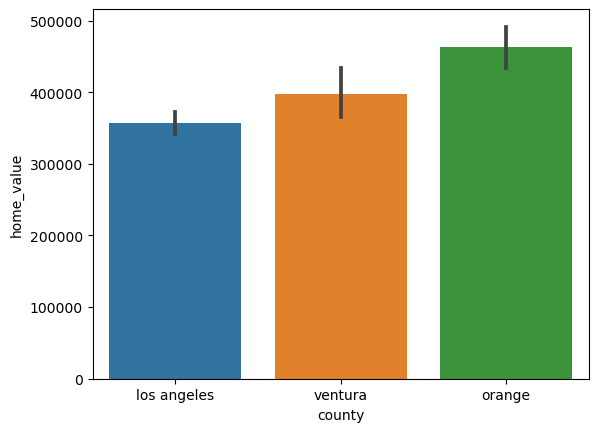

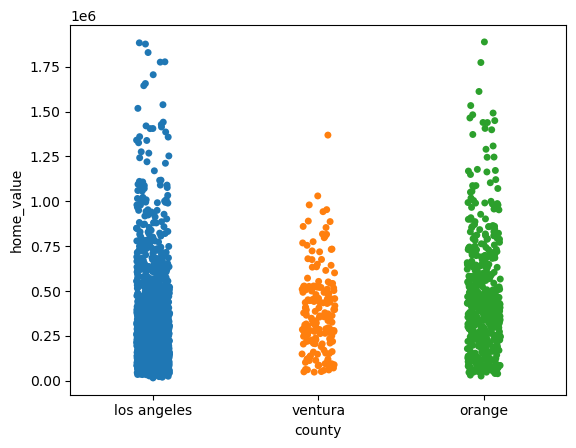

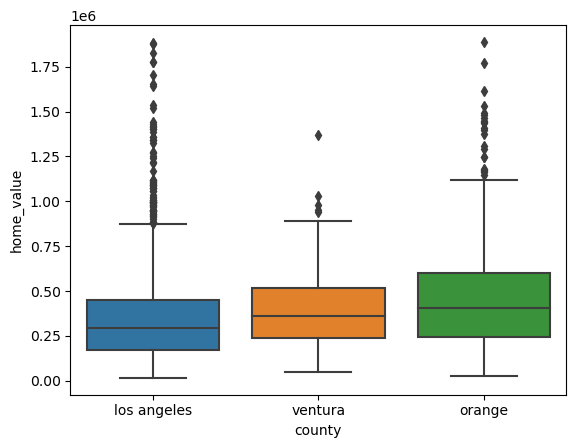

<Figure size 640x480 with 0 Axes>

In [33]:
w.plot_categorical_and_continuous_vars(train, 'county', 'home_value')

### Stats testing

$H_0$: The month of the transaction is independent of the home price (Independent)

$H_a$:  The home price is dependent on the month of the transaction (Dependent)

𝜶 = 0.05

In [34]:
train['transaction_month']

6939     2
6471     2
44553    8
31088    6
4038     1
        ..
23030    5
24932    5
31680    6
29484    5
43893    8
Name: transaction_month, Length: 36128, dtype: int64

In [35]:
α = 0.05

month = train['transaction_month']
home_value = train['home_value']

corr, p_value = pearsonr(month, home_value)

if p_value < α:
    print("Reject the Null Hypothesis. There is a dependency between transactions date and home value.")
else:
    print("Fail to reject the Null Hypothesis. There is no dependency between months and home value.")


Reject the Null Hypothesis. There is a dependency between transactions date and home value.


**Takeaways**

Home values do seem to matter when you sell. Our statistical test suggest there is a dependect between transaction dat and home value

$H_0$: Orange County home values are <= Los Angeles and Ventura home values

$H_a$: Orange County home values are > than Los Angeles and Ventura home values (greater than)

𝜶 = 0.05

In [36]:
train.head()

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
6939,1977.0,6000.0,-0.022559,-118030874.0,33775466.0,2,3.0,4.0,6059.0,2334.0,687000.0,orange
6471,1952.0,7220.0,-0.023329,-118125470.0,33964006.0,2,2.0,3.0,6037.0,1330.0,74121.0,los angeles
44553,1954.0,6951.0,-0.127179,-118385820.0,33807786.0,8,2.0,3.0,6037.0,2571.0,143122.0,los angeles
31088,1996.0,5735.0,0.006475,-118833422.0,34221985.0,6,2.5,4.0,6111.0,2394.0,470066.0,ventura
4038,1904.0,6793.0,-0.006862,-118281348.0,34097180.0,1,2.0,4.0,6037.0,2051.0,107819.0,los angeles


In [37]:
train[train.county == 'la_county']

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county


In [38]:
def hyp3_test(train):
    ''' 
    This function takes in the train dataset and outputs the T-Test results for hypothesis 3
    in the zillow regression project addressing home value of homes in Orange County against
    homes in LA or Ventura.
    '''
    # Create the samples
    orange_homes = train[train.county == 'orange_county']['home_value']
    la_ventura_homes = train[(train.county == 'la_county')|(train.county == 'ventura_county')]['home_value']

    # Set alpha
    α = 0.05

    # Check for equal variances
    s, pval = stats.levene(orange_homes, la_ventura_homes)

    # Run the two-sample, one-tail T-test.
    # Use the results from checking for equal variances to set equal_var
    t, p = stats.ttest_ind(orange_homes, la_ventura_homes, equal_var=(pval > α))

    # Evaluate results based on the t-statistic and the p-value
    if p/2 < α and t < 0:
        print('''Reject the Null Hypothesis. 
            Findings suggest there is less value or equal value in Orange County homes than homes in LA or Ventura.''')
    else:
        print('''Fail to reject the Null Hypothesis. Findings suggest there is greater home values in Orange County homes than homes in LA or Ventura''')
        

In [39]:
hyp3_test(train)

Fail to reject the Null Hypothesis. Findings suggest there is greater home values in Orange County homes than homes in LA or Ventura


**Takeaways**

Orange County has higher home values than the other 2 counties.

## Feature Engineering

In [40]:
train_scaled, validate_scaled, test_scaled = w.mvp_scaled_data(train, validate, test)

train_scaled.shape, validate_scaled.shape, test_scaled.shape

((36128, 12), (18064, 12), (18064, 12))

In [41]:
train_scaled.head(3)

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
6939,1977.0,0.282066,0.467097,0.749035,0.315577,2,3.0,4.0,6059.0,0.251362,687000.0,orange
6471,1952.0,0.344633,0.467019,0.699049,0.452433,2,2.0,3.0,6037.0,0.124161,74121.0,los angeles
44553,1954.0,0.330837,0.456549,0.561477,0.339037,8,2.0,3.0,6037.0,0.281389,143122.0,los angeles


In [42]:
X_train_scaled = train_scaled[['lot_sqft','logerror','long', 'lat', 'sqft']]
y_train = train_scaled['home_value']

In [43]:
def select_kbest(x,y,k):
    
    f_selector = SelectKBest(f_regression, k = k)
    
    f_selector.fit(x, y)   
    
    f_select_mask = f_selector.get_support()

    f_selector.transform(x)
    
    
    return x.iloc[:,f_select_mask]

In [44]:
select_kbest(X_train_scaled, y_train, 2)

,lot_sqft,sqft
6939,0.282066,0.251362
6471,0.344633,0.124161
44553,0.330837,0.281389
31088,0.268475,0.258964
4038,0.322734,0.215507
...,...,...
23030,0.403867,0.233118
24932,0.303964,0.122134
31680,0.284886,0.194349
29484,0.289399,0.368554


In [45]:
validate_scaled.head(3)

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
1796,1992.0,0.316683,0.467820,0.714365,0.993118,1,2.0,3.0,6037.0,0.099962,143025.0,los angeles
20842,1923.0,0.189651,0.475993,0.528297,0.471639,5,1.0,2.0,6037.0,0.074243,61044.0,los angeles
40515,1923.0,0.265091,0.469453,0.587398,0.465124,8,1.0,2.0,6037.0,0.064361,192800.0,los angeles


In [46]:
X_train = train_scaled.drop(columns = ['year_built', 'home_value', 'fips'])
X_train = pd.get_dummies(X_train, columns = ['transaction_month', 'bathrooms', 'bedrooms', 'county'])


X_validate = validate_scaled.drop(columns = ['year_built', 'home_value', 'fips'])
X_validate = pd.get_dummies(X_validate, columns = ['transaction_month', 'bathrooms', 'bedrooms', 'county'])
y_validate = validate_scaled['home_value']


X_test = test_scaled.drop(columns = ['year_built', 'home_value', 'fips'])
X_test = pd.get_dummies(X_test, columns = ['transaction_month', 'bathrooms', 'bedrooms', 'county'])
y_test = test_scaled['home_value']

In [47]:
X_train

,lot_sqft,logerror,long,lat,sqft,transaction_month_1,transaction_month_2,transaction_month_3,transaction_month_4,transaction_month_5,...,bathrooms_6.0,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,county_los angeles,county_orange,county_ventura
6939,0.282066,0.467097,0.749035,0.315577,0.251362,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6471,0.344633,0.467019,0.699049,0.452433,0.124161,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
44553,0.330837,0.456549,0.561477,0.339037,0.281389,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
31088,0.268475,0.470024,0.324958,0.639693,0.258964,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4038,0.322734,0.468679,0.616681,0.549100,0.215507,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23030,0.403867,0.470336,0.685295,0.619816,0.233118,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
24932,0.303964,0.462688,0.767456,0.426662,0.122134,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
31680,0.284886,0.471006,0.725484,0.525851,0.194349,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
29484,0.289399,0.467349,0.876016,0.334446,0.368554,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [48]:
def rfe(x, y, k):
    
    lm = LinearRegression()

    rfe = RFE(lm, n_features_to_select = k)
    
    rfe.fit(x, y)
    
    ranks = rfe.ranking_

    columns = x.columns.tolist()
    
    feature_ranks = pd.DataFrame({'ranking': ranks,
                                 'feature': columns})
    
    return feature_ranks.sort_values('ranking').reset_index().drop(columns = ('index'))

In [50]:
train_scaled_sample = train_scaled.drop(columns = ['county','home_value'])

In [51]:
select_kbest(train_scaled_sample, y_train, 1)

,sqft
6939,0.251362
6471,0.124161
44553,0.281389
31088,0.258964
4038,0.215507
...,...
23030,0.233118
24932,0.122134
31680,0.194349
29484,0.368554


In [52]:
rfe(train_scaled_sample, y_train, 1)

,ranking,feature
0,1,sqft
1,2,lat
2,3,long
3,4,lot_sqft
4,5,bedrooms
5,6,bathrooms
6,7,logerror
7,8,fips
8,9,year_built
9,10,transaction_month


In [53]:
rfe(X_train, y_train, 5)

,ranking,feature
0,1,county_ventura
1,1,county_los angeles
2,1,county_orange
3,1,transaction_month_6
4,1,transaction_month_9
5,2,transaction_month_3
6,3,transaction_month_1
7,4,transaction_month_4
8,5,transaction_month_7
9,6,transaction_month_8


In [54]:
train.head(3)

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
6939,1977.0,6000.0,-0.022559,-118030874.0,33775466.0,2,3.0,4.0,6059.0,2334.0,687000.0,orange
6471,1952.0,7220.0,-0.023329,-118125470.0,33964006.0,2,2.0,3.0,6037.0,1330.0,74121.0,los angeles
44553,1954.0,6951.0,-0.127179,-118385820.0,33807786.0,8,2.0,3.0,6037.0,2571.0,143122.0,los angeles


In [55]:
train_scaled.head(3)

,year_built,lot_sqft,logerror,long,lat,transaction_month,bathrooms,bedrooms,fips,sqft,home_value,county
6939,1977.0,0.282066,0.467097,0.749035,0.315577,2,3.0,4.0,6059.0,0.251362,687000.0,orange
6471,1952.0,0.344633,0.467019,0.699049,0.452433,2,2.0,3.0,6037.0,0.124161,74121.0,los angeles
44553,1954.0,0.330837,0.456549,0.561477,0.339037,8,2.0,3.0,6037.0,0.281389,143122.0,los angeles


## Modeling

In [56]:
lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression()

In [57]:
lm_preds = lm.predict(X_train)

In [58]:
preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})
preds_df.head()

,actual,lm_preds
6939,687000.0,508416.0
6471,74121.0,278400.0
44553,143122.0,624128.0
31088,470066.0,461824.0
4038,107819.0,405888.0


In [59]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))
lm_rmse

234722.47699985784

In [60]:
lasso = LassoLars(alpha = 0.05)

In [61]:
lasso.fit(X_train, y_train)

LassoLars(alpha=0.05)

In [62]:
lasso_preds = lasso.predict(X_train)

In [63]:
preds_df['lasso_preds'] = lasso_preds
preds_df.head()

,actual,lm_preds,lasso_preds
6939,687000.0,508416.0,507342.296523
6471,74121.0,278400.0,275997.437348
44553,143122.0,624128.0,622728.202207
31088,470066.0,461824.0,462648.096588
4038,107819.0,405888.0,410034.547619


In [64]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

234681.58560335016

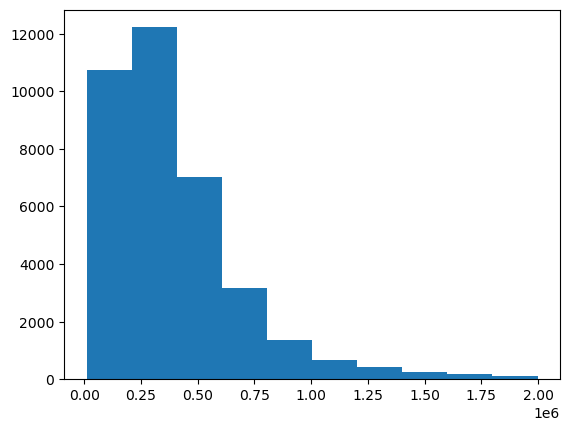

In [65]:
plt.hist(y_train)
plt.show()

In [66]:
tweedie = TweedieRegressor(power = 0)

tweedie.fit(X_train, y_train)

TweedieRegressor(power=0)

In [67]:
preds_df['tweedie'] = tweedie.predict(X_train)

preds_df

,actual,lm_preds,lasso_preds,tweedie
6939,687000.0,508416.0,507342.296523,443768.921661
6471,74121.0,278400.0,275997.437348,358445.552756
44553,143122.0,624128.0,622728.202207,362457.718215
31088,470066.0,461824.0,462648.096588,421125.046622
4038,107819.0,405888.0,410034.547619,383608.786773
...,...,...,...,...
23030,463419.0,373632.0,375514.322560,380835.111231
24932,178423.0,286720.0,284569.067443,357482.615568
31680,303959.0,326272.0,328985.216801,423194.050581
29484,488280.0,622976.0,623256.575199,445625.208050


In [68]:
tweedie_norm = sqrt(mean_squared_error(preds_df.actual, preds_df.tweedie))

tweedie_norm

289539.06846066413

In [69]:
tweedie_two = TweedieRegressor(power = 1)

tweedie_two.fit(X_train, y_train)

preds_df['tweedie_two'] = tweedie_two.predict(X_train)

In [70]:
tweedie_possion = sqrt(mean_squared_error(preds_df.actual, preds_df.tweedie_two))
tweedie_possion

238432.150629713

In [71]:
pf = PolynomialFeatures(degree = 2)

pf.fit(X_train, y_train)

PolynomialFeatures()

In [72]:
X_polynomial = pf.transform(X_train)

In [73]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

LinearRegression()

In [74]:
preds_df['poly_preds'] = lm2.predict(X_polynomial)

preds_df.head()

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,poly_preds
6939,687000.0,508416.0,507342.296523,443768.921661,497901.783423,481712.0
6471,74121.0,278400.0,275997.437348,358445.552756,286119.101568,273968.0
44553,143122.0,624128.0,622728.202207,362457.718215,591886.409609,660528.0
31088,470066.0,461824.0,462648.096588,421125.046622,436694.552095,451888.0
4038,107819.0,405888.0,410034.547619,383608.786773,374691.831109,410000.0


In [75]:
poly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

poly_rmse

228341.26647396767

In [76]:
lasso_two = LassoLars(alpha = 1)

lasso_two.fit(X_polynomial, y_train)

LassoLars(alpha=1)

In [77]:
preds_df['lasso_poly'] = lasso_two.predict(X_polynomial)

preds_df

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,poly_preds,lasso_poly
6939,687000.0,508416.0,507342.296523,443768.921661,497901.783423,481712.0,503690.720426
6471,74121.0,278400.0,275997.437348,358445.552756,286119.101568,273968.0,281042.012562
44553,143122.0,624128.0,622728.202207,362457.718215,591886.409609,660528.0,591334.768491
31088,470066.0,461824.0,462648.096588,421125.046622,436694.552095,451888.0,471174.254000
4038,107819.0,405888.0,410034.547619,383608.786773,374691.831109,410000.0,407404.888101
...,...,...,...,...,...,...,...
23030,463419.0,373632.0,375514.322560,380835.111231,332385.949830,384944.0,386206.763874
24932,178423.0,286720.0,284569.067443,357482.615568,292694.814695,233648.0,294834.670404
31680,303959.0,326272.0,328985.216801,423194.050581,350960.982735,308144.0,346732.859142
29484,488280.0,622976.0,623256.575199,445625.208050,612784.741136,673328.0,668959.433201


In [78]:
lasso_poly_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.lasso_poly))

lasso_poly_rmse

235871.09141678258

In [79]:
compare_models = pd.DataFrame({'model': ['linear', 'lasso', 'tweedie_norm', ' tweedie_possion', 'linear_poly', 'lasso_poly'],
              'rmse': [lm_rmse, lasso_rmse, tweedie_norm, tweedie_possion, poly_rmse, lasso_poly_rmse]})

In [80]:
preds_df['baseline'] = y_train.mean()

preds_df.head()

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,poly_preds,lasso_poly,baseline
6939,687000.0,508416.0,507342.296523,443768.921661,497901.783423,481712.0,503690.720426,387285.506975
6471,74121.0,278400.0,275997.437348,358445.552756,286119.101568,273968.0,281042.012562,387285.506975
44553,143122.0,624128.0,622728.202207,362457.718215,591886.409609,660528.0,591334.768491,387285.506975
31088,470066.0,461824.0,462648.096588,421125.046622,436694.552095,451888.0,471174.254000,387285.506975
4038,107819.0,405888.0,410034.547619,383608.786773,374691.831109,410000.0,407404.888101,387285.506975


In [81]:
baseline_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.baseline))
baseline_rmse

299641.38583791535

In [82]:
compare_models

,model,rmse
0,linear,234722.477000
1,lasso,234681.585603
2,tweedie_norm,289539.068461
3,tweedie_possion,238432.150630
4,linear_poly,228341.266474
5,lasso_poly,235871.091417


In [83]:
compare_models.loc[len(compare_models.index)] = ['baseline', baseline_rmse] 

In [84]:
pd.options.display.float_format = '{:.2f}'.format
compare_models.sort_values('rmse')

,model,rmse
4,linear_poly,228341.27
1,lasso,234681.59
0,linear,234722.48
5,lasso_poly,235871.09
3,tweedie_possion,238432.15
2,tweedie_norm,289539.07
6,baseline,299641.39


In [85]:
metrics = []



for i in np.arange(0.05, 1, .05):
    
    lasso = LassoLars(alpha = i )
    
    lasso.fit(X_train, y_train)
    
    lasso_preds = lasso.predict(X_train)
    
    preds_df['lasso_preds'] = lasso_preds

    lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
    
    output = {
            'alpha': i,
            'lasso_rmse': lasso_rmse
             }
    
    metrics.append(output)

df = pd.DataFrame(metrics)    
df.sort_values('lasso_rmse')

,alpha,lasso_rmse
0,0.05,234681.59
1,0.10,234681.62
2,0.15,234681.67
3,0.20,234681.74
4,0.25,234681.83
5,0.30,234681.94
6,0.35,234682.08
7,0.40,234682.23
8,0.45,234682.41
9,0.50,234682.60


In [86]:
metrics = []

for i in range(0, 4, 1):
    
    tweedie = TweedieRegressor(power = i)
    
    tweedie.fit(X_train, y_train)
    
    tweedie_preds = tweedie.predict(X_train)
    
    preds_df['tweedie_preds'] = tweedie_preds
    
    tweedie_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.tweedie_preds))
    
    output = {
            'power': i,
            'tweedie_rmse': tweedie_rmse
             }
    
    metrics.append(output)

df = pd.DataFrame(metrics)    
df.sort_values('tweedie_rmse')    

,power,tweedie_rmse
1,1,238432.15
0,0,289539.07
2,2,289765.22
3,3,299641.39


In [87]:
metrics = []

for i in np.arange(0.05, 1, .05):
    
    lasso_two = LassoLars(alpha = i)

    lasso_two.fit(X_polynomial, y_train)

    preds_df['lasso_poly'] = lasso_two.predict(X_polynomial)

    lasso_poly_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.lasso_poly))

    output = {
            'alpha': i,
            'lasso_poly_rmse': lasso_poly_rmse
             }
    
    metrics.append(output)

df = pd.DataFrame(metrics)    
df.sort_values('lasso_poly_rmse')   

,alpha,lasso_poly_rmse
0,0.05,235871.09
16,0.85,235871.09
15,0.80,235871.09
14,0.75,235871.09
13,0.70,235871.09
12,0.65,235871.09
11,0.60,235871.09
10,0.55,235871.09
17,0.90,235871.09
9,0.50,235871.09


In [88]:
metrics = []

for i in range(2,4):
    
    pf = PolynomialFeatures(degree = i)
    
    pf.fit(X_train, y_train)

    X_polynomial = pf.transform(X_train)

    lm2 = LinearRegression()

    lm2.fit(X_polynomial, y_train)

    preds_df['poly_preds'] = lm2.predict(X_polynomial)

    poly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

    output = {
            'degree': i,
            'poly_rmse': poly_rmse
             }
    
    metrics.append(output)

df = pd.DataFrame(metrics)    
df.sort_values('poly_rmse')   

,degree,poly_rmse
1,3,217147.98
0,2,228341.27


In [89]:
best_models = pd.DataFrame({'model': ['linear', 'lasso', ' tweedie_possion', 'linear_poly', 'lasso_poly','baseline'],
              'rmse': [lm_rmse, lasso_rmse, tweedie_possion, poly_rmse, lasso_poly_rmse, baseline_rmse]})

In [90]:
best_train_models = best_models.sort_values('rmse').reset_index().drop(columns = ['index'])

best_train_models

,model,rmse
0,linear_poly,217147.98
1,lasso,234685.28
2,linear,234722.48
3,lasso_poly,235871.09
4,tweedie_possion,238432.15
5,baseline,299641.39


In [93]:
preds_df['actual_val'] = y_validate
preds_df['actual_test'] = y_test

In [123]:
pf = PolynomialFeatures(degree = 3)
    
pf.fit(X_train, y_train)
X_train_d3 = pf.transform(X_train)

X_validate_d3 = pf.transform(X_validate)
X_test_d3 = pf.transform(X_test)

lm2 = LinearRegression()
lm2.fit(X_train_d3, y_train)

preds_df['poly_preds'] = lm2.predict(X_train_d3)
train_rmse = sqrt(mean_squared_error(preds_df.actual,preds_df['poly_preds']))

In [137]:
val_preds_df = pd.DataFrame({'actual_val': y_validate
                            })
val_preds_df

,actual_val
1796,143025.00
20842,61044.00
40515,192800.00
11411,661943.00
46198,533006.00
...,...
51503,236754.00
32118,1155810.00
1577,361663.00
40307,167966.00


In [138]:
val_preds_df['poly_vals'] = lm2.predict(X_validate_d3)

val_preds_df

,actual_val,poly_vals
1796,143025.00,24608.00
20842,61044.00,308256.00
40515,192800.00,256288.00
11411,661943.00,474368.00
46198,533006.00,279232.00
...,...,...
51503,236754.00,335712.00
32118,1155810.00,1350560.00
1577,361663.00,409760.00
40307,167966.00,645056.00


In [144]:
test_preds_df = pd.DataFrame({'actual_test': y_test
                            })
test_preds_df

,actual_test
1099,426408.00
30910,288212.00
49676,331446.00
3106,32050.00
23571,323642.00
...,...
39979,384047.00
11320,674416.00
6590,872325.00
7019,266548.00


In [145]:
test_preds_df['poly_test'] = lm2.predict(X_test_d3)
test_preds_df.head()

,actual_test,poly_test
1099,426408.00,337152.00
30910,288212.00,409600.00
49676,331446.00,254368.00
3106,32050.00,186112.00
23571,323642.00,272032.00


In [174]:
poly_validate_rmse = sqrt(mean_squared_error(val_preds_df.actual_val, val_preds_df['poly_vals']))

poly_test_rmse = sqrt(mean_squared_error(test_preds_df.actual_test, test_preds_df['poly_test']))
validate_rmse, test_rmse

(215540.63383958949, 218743.5234421221)

In [96]:
preds_df.head()

,actual,lm_preds,lasso_preds,tweedie,tweedie_two,poly_preds,lasso_poly,baseline,tweedie_preds,actual_val,actual_test
6939,687000.00,508416.00,507486.20,443768.92,497901.78,401568.00,503690.72,387285.51,387285.51,NaN,687000.00
6471,74121.00,278400.00,276011.50,358445.55,286119.10,261664.00,281042.01,387285.51,387285.51,NaN,74121.00
44553,143122.00,624128.00,622522.02,362457.72,591886.41,640672.00,591334.77,387285.51,387285.51,NaN,143122.00
31088,470066.00,461824.00,463748.38,421125.05,436694.55,462272.00,471174.25,387285.51,387285.51,470066.00,NaN
4038,107819.00,405888.00,410548.61,383608.79,374691.83,372512.00,407404.89,387285.51,387285.51,NaN,107819.00


In [147]:
rmse_df = pd.DataFrame({'data': ['train','validate','test'],
                        'rmse': [train_rmse, validate_rmse, test_rmse]
                       })
rmse_df

,data,rmse
0,train,217147.98
1,validate,215540.63
2,test,218743.52


In [150]:
lasso = LassoLars(alpha = 0.05)
    
lasso.fit(X_train, y_train)
    
lasso_val = lasso.predict(X_validate)
    
val_preds_df['lasso_preds'] = lasso_val

lasso_rmse_val = sqrt(mean_squared_error(val_preds_df['actual_val'],val_preds_df['lasso_preds']))
    

In [151]:
val_preds_df

,actual_val,poly_vals,lasso_preds
1796,143025.00,24608.00,83785.44
20842,61044.00,308256.00,256111.54
40515,192800.00,256288.00,238379.47
11411,661943.00,474368.00,401998.87
46198,533006.00,279232.00,256784.83
...,...,...,...
51503,236754.00,335712.00,388300.24
32118,1155810.00,1350560.00,1094847.67
1577,361663.00,409760.00,487154.92
40307,167966.00,645056.00,638179.93


In [172]:
lm_val = lm.predict(X_validate)

val_preds_df['lm_preds'] = lm_val

lm_rmse_val = sqrt(mean_squared_error(val_preds_df['actual_val'], val_preds_df['lm_preds']))

In [173]:
lasso_rmse, lasso_rmse_val, lm_rmse_val

(234685.27946595984, 232887.89326538687, 232936.5027350161)

In [167]:
train_val_model_compare = best_train_models.loc[:2]

In [168]:
train_val_model_compare = train_val_model_compare.rename(columns = {'rmse': 'train_rmse'})

train_val_model_compare.head()

,model,train_rmse
0,linear_poly,217147.98
1,lasso,234685.28
2,linear,234722.48


In [175]:
train_val_model_compare['val_rmse'] = [poly_validate_rmse,lasso_rmse_val,lm_rmse_val]

train_val_model_compare

,model,train_rmse,val_rmse
0,linear_poly,217147.98,215540.63
1,lasso,234685.28,232887.89
2,linear,234722.48,232936.50


- look at difference between train and validate
- final notebook